# Import Everything I Need

In [30]:
## Essential Imports: 
import os
import numpy as np
from pathlib import Path
from pzflow.examples import get_galaxy_data
import tables_io

## RAIL-Specific Imports: 
import rail
from rail.creation.degradation import LSSTErrorModel, InvRedshiftIncompleteness
from rail.creation.engines.flowEngine import FlowModeler, FlowCreator, FlowPosterior
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.core.utilStages import ColumnMapper, TableConverter

from rail.estimation.algos.flexzboost import Inform_FZBoost, FZBoost

from rail.evaluation.evaluator import Evaluator

## Data Storage: 
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

## Data Formatting: (from different codes) 
from rail.core.utils import RAILDIR
flow_file = os.path.join(RAILDIR, 'examples/goldenspike/data/pretrained_flow.pkl')
bands = ['u','g','r','i','z','y']
band_dict = {band:f'mag_{band}_lsst' for band in bands}
rename_dict = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

# Setting Up the Flow Engine 

In [31]:
#path to access the data 
DATA_DIR = Path().resolve() / "data"
DATA_DIR.mkdir(exist_ok=True)

catalog_file = DATA_DIR / "base_catalog.pq"

#array of 100,000 galaxies w/ 7 attributes for each: redshift & ugrizy
catalog = get_galaxy_data().rename(band_dict, axis=1) 

#turns array into a table 
tables_io.write(catalog, str(catalog_file.with_suffix("")), catalog_file.suffix[1:])

catalog_file = str(catalog_file)
flow_file = str(DATA_DIR / "trained_flow.pkl")

#we set up the stage 
flow_modeler_params = {
    "name": "flow_modeler",
    "input": catalog_file,
    "model": flow_file,
    "seed": 0,
    "phys_cols": {"redshift": [0, 3]},
    "phot_cols": {
        "mag_u_lsst": [17, 35],
        "mag_g_lsst": [16, 32],
        "mag_r_lsst": [15, 30],
        "mag_i_lsst": [15, 30],
        "mag_z_lsst": [14, 29],
        "mag_y_lsst": [14, 28],
    },
    "calc_colors": {"ref_column_name": "mag_i_lsst"},
}

#we make the stage
flow_modeler = FlowModeler.make_stage(**flow_modeler_params)

#we use the stage to make a model 
flow_modeler.fit_model()

#now we have a model; the next thing to do is to pull datasets from it (and degrade them)

Training 30 epochs 
Loss:
(0) 21.3266
(1) 3.9642
(2) 3.5612
(3) 1.6287
(4) -0.0812
(5) 0.2244
(6) -0.2572
(7) 0.3581
(8) -0.7755
(9) -1.4998
(10) -1.6085
(11) -1.7710
(12) -2.4134
(13) -2.2855
(14) -2.3888
(15) -1.3606
(16) -2.2746
(17) -1.7556
(18) -2.1972
(19) -3.2067
(20) -3.0266
(21) -3.2861
(22) -2.6768
(23) -3.3777
(24) -2.1020
(25) -2.9262
(26) -3.9119
(27) -3.4481
(28) -4.1449
(29) -3.9272
(30) -3.5161
Inserting handle into data store.  model_flow_modeler: /global/u2/a/acraffor/Photo-z-Stress-Test/data/inprogress_trained_flow.pkl, flow_modeler


# Training Set  

In [41]:
#take a sample of 10,000 galaxies from the model created above to use as a training set
flow_creator_train = FlowCreator.make_stage(
    name='flow_creator_train', 
    model=flow_modeler.get_handle("model"), 
    n_samples=10000,
    seed=1235,
)

#an un-degraded training data set containing 10,000 galaxies
orig_train_data = flow_creator_train.sample(10000, 1235)

# the inverse redshift degrader stage
inv_redshift_deg = InvRedshiftIncompleteness.make_stage(
    name='inv_redshift_deg',
    pivot_redshift=1.0,
)

#degraded training set, using inverse redshift degrader 
deg_train_data = inv_redshift_deg(orig_train_data)


Inserting handle into data store.  output_flow_creator_train: inprogress_output_flow_creator_train.pq, flow_creator_train
Inserting handle into data store.  output_inv_redshift_deg: inprogress_output_inv_redshift_deg.pq, inv_redshift_deg


In [42]:
#stages for making tables 
col_remapper = ColumnMapper.make_stage(
    name='col_remapper', 
    columns=rename_dict,
)
   
table_conv = TableConverter.make_stage(
    name='table_conv', 
    output_format='numpyDict',
)

In [43]:
#actually make the tables: 

#un-degraded training data 
orig_train_data_pq = col_remapper(orig_train_data)
table_1_data = table_conv(orig_train_data_pq)

table_1 = tables_io.convertObj(table_1_data.data, tables_io.types.PD_DATAFRAME)
table_1

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,1.264517,27.786419,27.242987,26.685568,26.233591,25.613094,25.169724
1,1.313446,26.115280,25.873371,25.734262,25.399487,24.839447,24.345036
2,0.409717,27.210604,26.284395,25.286398,24.991396,24.891602,24.605812
3,0.290005,27.169312,26.874529,26.485617,26.415546,26.179346,26.287651
4,1.730289,28.057541,27.228115,26.649137,26.153965,25.717478,25.449621
...,...,...,...,...,...,...,...
9995,1.605779,27.042044,26.828970,26.608923,26.264484,25.991825,25.593315
9996,0.458197,28.139051,27.107420,26.075956,25.703279,25.475811,25.327438
9997,0.930603,27.366280,26.990480,26.163568,25.242893,24.674709,36.393253
9998,0.845785,25.911119,25.284060,24.630331,23.819296,23.513479,23.440834


In [44]:
#degraded training data 
deg_train_data_pq = col_remapper(deg_train_data)
table_2_data = table_conv(deg_train_data_pq)

table_2 = tables_io.convertObj(table_2_data.data, tables_io.types.PD_DATAFRAME)
table_2

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,1.264517,27.786419,27.242987,26.685568,26.233591,25.613094,25.169724
1,1.313446,26.115280,25.873371,25.734262,25.399487,24.839447,24.345036
2,0.409717,27.210604,26.284395,25.286398,24.991396,24.891602,24.605812
3,0.290005,27.169312,26.874529,26.485617,26.415546,26.179346,26.287651
4,1.730289,28.057541,27.228115,26.649137,26.153965,25.717478,25.449621
...,...,...,...,...,...,...,...
8591,1.605779,27.042044,26.828970,26.608923,26.264484,25.991825,25.593315
8592,0.458197,28.139051,27.107420,26.075956,25.703279,25.475811,25.327438
8593,0.930603,27.366280,26.990480,26.163568,25.242893,24.674709,36.393253
8594,0.845785,25.911119,25.284060,24.630331,23.819296,23.513479,23.440834


# Test Set

In [45]:
#take a sample of 100,000 galaxies from the model created above to use as a test set
flow_creator_test = FlowCreator.make_stage(
    name='flow_creator_test', 
    model=flow_modeler.get_handle("model"), 
    n_samples=100000,
    seed=472,
)

#un-degraded test data set, 100,000 galaxies 
orig_test_data = flow_creator_test.sample(100000, 472)

#the LSST error model degrader
lsst_error_model_deg = LSSTErrorModel.make_stage(
    name='lsst_error_model_deg',
    bandNames=band_dict, 
    seed=29,
)

#degraded test set, using LSST error model 
deg_test_data = lsst_error_model_deg(orig_test_data,seed=66)


Inserting handle into data store.  output_flow_creator_test: inprogress_output_flow_creator_test.pq, flow_creator_test
Inserting handle into data store.  output_lsst_error_model_deg: inprogress_output_lsst_error_model_deg.pq, lsst_error_model_deg


In [46]:
#test tables: (note; these will not run without running the above cell that defines the table-making stages)

#un-degraded test data 
orig_test_data_pq = col_remapper(orig_test_data)
table_3_data = table_conv(orig_test_data_pq)

table_3 = tables_io.convertObj(table_3_data.data, tables_io.types.PD_DATAFRAME)
table_3

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,0.157401,27.432207,26.275665,25.838562,25.603338,25.588392,25.582487
1,0.305059,26.002398,25.277248,24.714016,24.565414,24.409430,24.430435
2,0.919661,36.043938,35.275528,27.617905,26.049702,24.586761,23.332638
3,2.006808,30.154133,29.384552,28.316244,27.644444,26.420568,25.555367
4,0.376370,27.003794,26.267574,25.476799,25.395592,25.173195,25.219444
...,...,...,...,...,...,...,...
99995,1.399395,25.913628,25.691242,25.548355,25.134371,24.754108,24.129515
99996,1.400929,28.693521,27.928488,27.241772,26.486341,26.134819,25.489656
99997,1.100379,27.048498,26.363762,25.498039,24.709269,23.825960,23.545732
99998,1.476400,27.577494,27.154160,26.819090,26.263683,25.900063,25.264446


In [47]:
#degraded test data 
deg_test_data_pq = col_remapper(deg_test_data)
table_4_data = table_conv(deg_test_data_pq)

table_4 = tables_io.convertObj(table_4_data.data, tables_io.types.PD_DATAFRAME)
table_4

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


,redshift,mag_u_lsst,mag_err_u_lsst,mag_g_lsst,mag_err_g_lsst,mag_r_lsst,mag_err_r_lsst,mag_i_lsst,mag_err_i_lsst,mag_z_lsst,mag_err_z_lsst,mag_y_lsst,mag_err_y_lsst
0,0.157401,27.074721,0.453704,26.322702,0.085545,25.866620,0.056194,25.677890,0.070456,25.761232,0.132764,26.141540,0.391248
1,0.305059,25.901689,0.176566,25.239311,0.032832,24.704959,0.020274,24.557828,0.026174,24.397457,0.039912,24.442777,0.094576
2,0.919661,27.818106,0.767680,NaN,NaN,27.346630,0.203674,26.065868,0.099175,24.589430,0.047320,23.377645,0.036841
3,2.006808,29.574165,1.977175,27.780178,0.295297,28.356634,0.456537,27.838048,0.431465,26.323373,0.214177,25.312620,0.200065
4,0.376370,26.559566,0.303933,26.328453,0.085979,25.525672,0.041519,25.456796,0.057917,25.178087,0.079726,25.727459,0.281810
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.399395,26.286662,0.243501,25.684588,0.048654,25.595678,0.044180,25.141851,0.043790,24.736893,0.053938,24.182850,0.075220
99996,1.400929,28.726752,1.320030,27.644924,0.264619,27.400125,0.213000,26.279725,0.119534,26.604098,0.269995,25.646528,0.263850
99997,1.100379,26.471265,0.283076,26.346592,0.087362,25.524756,0.041486,24.716111,0.030060,23.805856,0.023754,23.566353,0.043544
99998,1.476400,26.922827,0.404248,27.285454,0.196421,26.783384,0.125906,26.419547,0.134933,25.850217,0.143356,25.634184,0.261202


# Informative Plots :) 

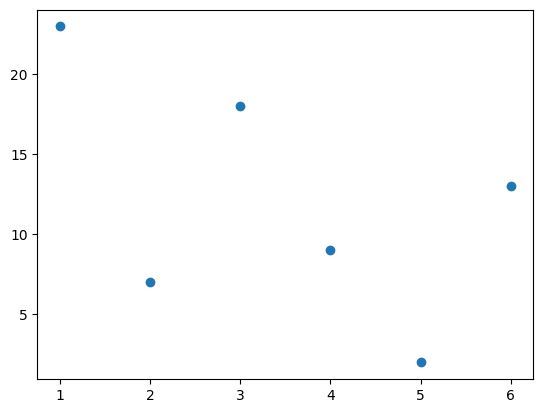

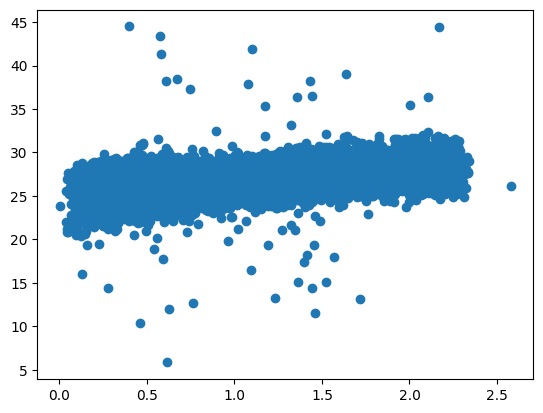

In [82]:
import matplotlib.pyplot as plt
#import corner.py

data_1 = np.asarray(table_1)

redshift_1 = data_1[:,0]
u_1 = data_1[:, 1]
g_1 = data_1[:, 2]
r_1 = data_1[:, 3]
i_1 = data_1[:, 4]
z_1 = data_1[:, 5]
y_1 = data_1[:, 6]

plt.scatter(redshift_1, u_1)
plt.show()

# Perform Estimations with FlexzBoost

In [6]:
###

# Evaluate Using Performance Metrics 

In [7]:
###